In [1]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
%matplotlib inline

In [2]:
fpath = 'facebook_data_WSJ_post_sentiment.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,PositiveScore,NegativeScore,NeutralScore,SentimentScore,TokenQnt,PositiveScoreAvg,NegativeScoreAvg,NeutralScoreAvg,SentimentScoreAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound,Flair_Score
0,1,10161085588958128,2021-05-16 19:01:04,This quick beans and rice recipe gets a little...,4,0,0.875,0.375,9.75,0.50,11,0.079545,0.034091,0.886364,0.045455,0.249,0.000,0.751,0.8074,0.9913
1,2,10161085508038128,2021-05-16 18:35:05,Jimmy Kimmel wore a white lab coat and head mi...,37,1,0.875,1.625,23.50,-0.75,26,0.033654,0.062500,0.903846,-0.028846,0.041,0.026,0.933,0.2732,-0.9119
2,3,10161085417148128,2021-05-16 18:00:35,Government efforts to boost economic activity ...,28,3,0.500,1.500,16.00,-1.00,18,0.027778,0.083333,0.888889,-0.055556,0.124,0.046,0.830,0.5574,-0.9956
3,4,10161085362453128,2021-05-16 17:30:18,"As the U.S. real-estate market picks up, incre...",42,4,0.250,0.500,19.25,-0.25,20,0.012500,0.025000,0.962500,-0.012500,0.040,0.103,0.857,-0.3182,-0.5241
4,5,10161085218303128,2021-05-16 16:30:17,Some retailers are grooming their own data sci...,117,9,0.000,0.000,12.00,0.00,12,0.000000,0.000000,1.000000,0.000000,0.058,0.000,0.942,0.2023,-0.9983


In [3]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

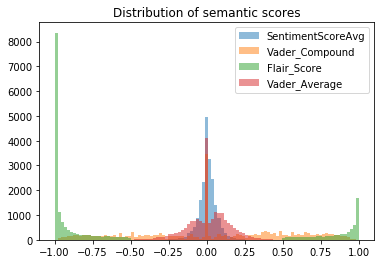

In [4]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['SentimentScoreAvg'], bins, alpha=0.5, label='SentimentScoreAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Flair_Score'], bins, alpha=0.5, label='Flair_Score')
pyplot.hist(post_data['Vader_Average'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

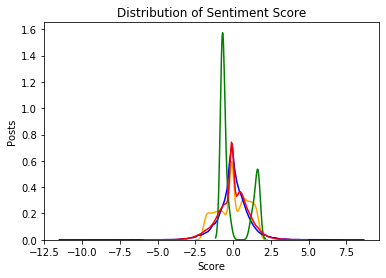

In [5]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['SentimentScoreAvg'] - post_data['SentimentScoreAvg'].mean())/post_data['SentimentScoreAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Flair_Score'] - post_data['Flair_Score'].mean())/post_data['Flair_Score'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [6]:
post_data[['SentimentScoreAvg','Vader_Compound','Flair_Score','Vader_Average']].describe()

,SentimentScoreAvg,Vader_Compound,Flair_Score,Vader_Average
count,20383.000000,20383.000000,20383.000000,20383.000000
mean,0.007444,0.047642,-0.403766,0.011205
std,0.056501,0.512540,0.823037,0.137184
min,-0.625000,-0.987000,-1.000000,-0.744000
25%,-0.018750,-0.340000,-0.996700,-0.065000
50%,0.004310,0.000000,-0.940300,0.000000
75%,0.035714,0.476700,0.659650,0.095000
max,0.479167,0.982100,1.000000,0.632000


In [7]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [9]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [10]:
Monthly_Data = post_data.groupby('DateMonth').agg({'SentimentScore': 'sum'
                                                         ,'TokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'Flair_Score':'mean'})

In [11]:
DailyData = post_data.groupby('DateDay').agg({'SentimentScore': 'sum'
                                                         ,'TokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'Flair_Score':'mean'})

In [12]:
DailyData['SentimentScoreAdj'] = DailyData['SentimentScore']/DailyData['TokenQnt']
Monthly_Data['SentimentScoreAdj'] = Monthly_Data['SentimentScore']/Monthly_Data['TokenQnt']


In [13]:
DailyData.head()

,SentimentScore,TokenQnt,Vader_Compound,Vader_Average,Flair_Score,SentimentScoreAdj
DateDay,,,,,,
2009-01-15,0.125,2,0.34540,0.036000,-0.825800,0.062500
2009-01-16,1.500,4,0.24755,0.185750,-0.382725,0.375000
2009-01-18,0.000,1,0.00000,0.000000,0.762300,0.000000
2009-01-20,0.375,3,0.31480,0.088333,-0.194367,0.125000
2009-01-21,2.500,3,0.30860,0.042667,-0.977100,0.833333


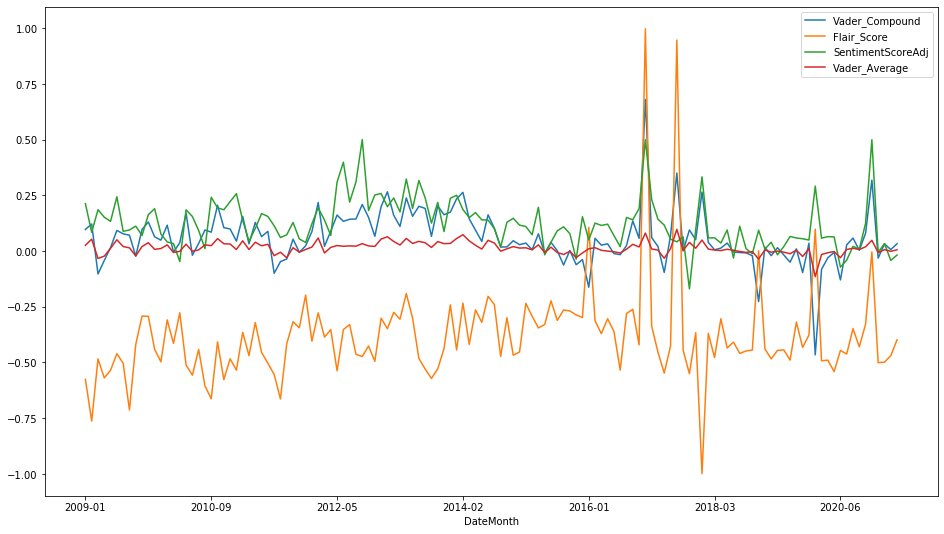

In [14]:
Monthly_Data[['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [50]:
SnP_daily = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='m')

In [51]:
SnP_monthly

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-10-01,1196.140015,1131.869995,1143.489990,1183.260010,89536270000,1183.260010
2010-11-01,1227.079956,1173.000000,1185.709961,1180.550049,87151070000,1180.550049
2010-12-01,1262.599976,1186.599976,1186.599976,1257.640015,80984530000,1257.640015
2011-01-01,1302.670044,1257.619995,1257.619995,1286.119995,92164940000,1286.119995
2011-02-01,1344.069946,1289.140015,1289.140015,1327.219971,59223660000,1327.219971
...,...,...,...,...,...,...
2021-01-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990
2021-02-01,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902
2021-03-01,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893


In [52]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [53]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [54]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [55]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [56]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [57]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [58]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,SentimentScore,TokenQnt,Vader_Compound,Vader_Average,Flair_Score,SentimentScoreAdj
2010-10,1196.140015,1131.869995,1143.489990,1183.260010,89536270000,1183.260010,NaN,15.750000,81,0.205695,0.056000,-0.407678,0.194444
2010-11,1227.079956,1173.000000,1185.709961,1180.550049,87151070000,1180.550049,-0.002293,16.875000,91,0.105324,0.033143,-0.577119,0.185440
2010-12,1262.599976,1186.599976,1186.599976,1257.640015,80984530000,1257.640015,0.063256,10.000000,45,0.099407,0.031644,-0.483293,0.222222
2011-01,1302.670044,1257.619995,1257.619995,1286.119995,92164940000,1286.119995,0.022393,20.375000,79,0.044758,0.007443,-0.534478,0.257911
2011-02,1344.069946,1289.140015,1289.140015,1327.219971,59223660000,1327.219971,0.031457,17.125000,124,0.155724,0.046169,-0.364747,0.138105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990,-0.011199,1.000000,2,0.318450,0.048500,-0.003800,0.500000
2021-02,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902,0.025757,-1.888000,308,-0.031419,-0.006912,-0.500916,-0.006130
2021-03,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893,0.041563,17.556000,519,0.032541,0.006784,-0.498397,0.033827
2021-04,4218.779785,3992.780029,3992.780029,4181.169922,82869290000,4181.169922,0.051097,-24.228328,581,0.006683,-0.000909,-0.470068,-0.041701


In [59]:
gc_res = grangercausalitytests(Granger_data_daily[["LogReturn","Vader_Compound"]].dropna(),11)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8319  , p=0.0504  , df_denom=1774, df_num=1
ssr based chi2 test:   chi2=3.8384  , p=0.0501  , df=1
likelihood ratio test: chi2=3.8342  , p=0.0502  , df=1
parameter F test:         F=3.8319  , p=0.0504  , df_denom=1774, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7739  , p=0.1700  , df_denom=1771, df_num=2
ssr based chi2 test:   chi2=3.5578  , p=0.1688  , df=2
likelihood ratio test: chi2=3.5542  , p=0.1691  , df=2
parameter F test:         F=1.7739  , p=0.1700  , df_denom=1771, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0351  , p=0.1070  , df_denom=1768, df_num=3
ssr based chi2 test:   chi2=6.1295  , p=0.1055  , df=3
likelihood ratio test: chi2=6.1190  , p=0.1060  , df=3
parameter F test:         F=2.0351  , p=0.1070  , df_denom=1768, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7168  , p=0.

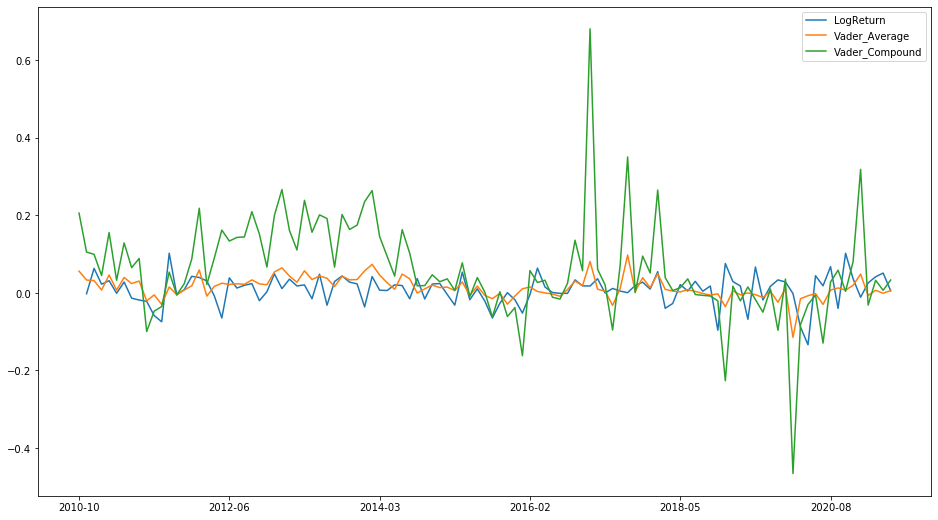

In [33]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [34]:
corr = Granger_data_daily[['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average', 'LogReturn']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Flair_Score,SentimentScoreAdj,Vader_Average,LogReturn
Vader_Compound,1.000000,0.237375,0.421607,0.904405,0.024251
Flair_Score,0.237375,1.000000,0.126345,0.236614,0.024030
SentimentScoreAdj,0.421607,0.126345,1.000000,0.378771,0.019746
Vader_Average,0.904405,0.236614,0.378771,1.000000,0.023152
LogReturn,0.024251,0.024030,0.019746,0.023152,1.000000


In [35]:
pvals = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif

,p-value
Vader_Compound,0.306768
Flair_Score,0.311200
SentimentScoreAdj,0.405336
Vader_Average,0.329231


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369
